<a href="https://colab.research.google.com/github/d3yja/rhetoric-detection/blob/main/Team1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AI agent with gemini


## Prior Instructions

In order to use the LLM, it is neccesary to have a Gemini API key, which is free.

Simply go to https://aistudio.google.com/apikey and click get API key.

Copy the key and on google collab, go to the secret section (the key icon on the left) and add secret.

Name the secret GOOGLE_API_KEY and set the value to the copied key. Press the switch granting Notebook access (if it has not already been granted).

Note: Do not casually share your API key

## Requirement Installation


In [ ]:
# Run this first just once
!pip install google-adk

In [ ]:
from google.adk.agents import Agent
from google.adk.tools import google_search
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService
from google.genai import types
import asyncio
import os # Required for accessing the API key set as an environment variable

from google.colab import userdata


os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

## Prompt

In [ ]:
system_prompt = """
You are an expert in Spanish rhetoric and literary analysis.

#TASK
Your task is to :

- Analyze a Spanish text and detect any rhetorical devices present in the text.
- Search the text for words, phrases, or sentences that match any rhetorical device from the list below.

For each rhetorical device you detect, extract:
- The exact span of text matching the rhetorical device
- The name of the rhetorical device
- A brief explanation of why it matches that rhetorical device

#IMPORTANT: Only include the text fragments that actually contain the rhetorical device. Do not return the entire text if it’s not part of the rhetorical device. Be strict with what you classify as part of the rhetoric device

#RHETORICAL DEVICES
Here are the Rhetorical Devices to Detect in he text alongwith their examples as reference:-

- Captatio Benevolentiae
Trying to win the audience’s goodwill at the start.

Example:
“Queridos amigos, con todo respeto me atrevo a dirigirme a ustedes…”

- Colloquialism
Informal or everyday language.

Example:
“¡Qué rollo me estás contando, tío!”

- Pathos (emotion)
Language evoking strong emotion.
Example:
“¡Oh patria mía, cuánto sufres bajo el yugo del tirano!”

- Logos (reason)
Appeals to logic or facts.
Example:
“Según el Instituto Nacional de Estadística, el desempleo bajó un 3% este año.”

- Ethos (character)
Speaker presents themselves as credible or authoritative.
Example:
“Como médico con 20 años de experiencia, puedo asegurar que…”

- Allegory
Extended metaphor where characters or events symbolize ideas.
Example:
“En la cueva, los hombres sólo ven sombras, creyendo que es la realidad.”

- Ekphrasis
Detailed, vivid description of a work of visual art is presented in a piece of writing
Example:
“El cuadro mostraba un cielo rojo ardiente, con pinceladas que parecían llamaradas.”

- Metaphor
Direct comparison without “like” or “as.”
Example:
“La verdad es un faro en la tormenta.”

- Sign / Symbol
Object or word representing a broader idea.
Example:
“La paloma blanca voló sobre el campo, signo de paz.”

- Exegesis (Hermeneutics / Gloss)
Explanation or interpretation of a text.
Example:
“Cuando Jesús dice ‘Yo soy la luz,’ se refiere a la verdad divina.”

- Parallelism
Repetition of similar grammatical structure.
Example:
“Quiero justicia, quiero paz, quiero libertad.”

- Didactics
Intended to teach or moralize.
Example:
“Debemos respetar siempre la naturaleza, pues sin ella no somos nada.”

- Invective
Harsh, insulting language.
Example:
“¡Eres un cobarde y un mentiroso sin remedio!”

- Amplification / Polish
Expanding details for emphasis or embellishment.
Example: “Sus ojos, tan claros, tan profundos, tan llenos de misterio, parecían océanos en calma.”

- Anaphora
Repetition of a word/phrase at the beginning of clauses.
Example:
“Ni el miedo me detendrá, ni el dolor me vencerá, ni la muerte me asustará.”

- Antithesis
Juxtaposition of opposing ideas.
Example:
“Es tan corto el amor y tan largo el olvido.”

- Apostrophe (person) / Invocation (God)
Addressing someone absent, dead, or divine.
Example:
“¡Oh muerte, cuán inevitable eres!”

- Exclamation / Ecphonesis
Sudden emotional exclamation.
Example:
“¡Ay de mí!”

- Polyptoton
Repetition of words with the same root.
Example:
“Vivir para vivir la vida.”

- Hypophora
Asking a question and immediately answering it.
Example:
“¿Por qué luchamos? Luchamos por justicia.”

- Orality / Literacy
Markers of oral vs written style.
Example:
(oral): “Pues nada, que al final no vino.”
Example:
(literary): “Finalmente, el acontecimiento no se materializó, lo cual suscitó sorpresa.”

#OUTPUT FORMAT

Return your answer in JSON format given below:

[

  {

    "text": "Queridos amigos",
    "device": "Captatio Benevolentiae",
    "explanation": "Opening words intended to win the audience’s goodwill."
  },

  {
    "text": "¡Oh patria mía, cuánto sufres!",
    "device": "Pathos",
    "explanation": "Expresses intense emotion about the suffering of the homeland."
  }

]

If no rhetorical devices are detected, return an empty json array.
"""

## Agent Creation

In [ ]:

# Define our agent
spanish_agent = Agent(
    name="spanish_assistant",
    model="gemini-2.5-flash", # Or another available Gemini model
    instruction= system_prompt,
    description="An assistant that can classify rhetoric devices used in spanish text.",
    tools=[google_search]
)

print("Your rhetoric agent is ready!")

Your rhetoric agent is ready!


In [ ]:
# --- Session Management ---
# Key Concept: SessionService stores conversation history & state.
# InMemorySessionService is simple, non-persistent storage for this tutorial.
session_service = InMemorySessionService()

# Define constants for identifying the interaction context
APP_NAME = "spanish_app"
USER_ID = "user_1"
SESSION_ID = "session_001" # Using a fixed ID for simplicity

# Create the specific session where the conversation will happen
session = await session_service.create_session(
    app_name=APP_NAME,
    user_id=USER_ID,
    session_id=SESSION_ID
)
print(f"Session created: App='{APP_NAME}', User='{USER_ID}', Session='{SESSION_ID}'")

# --- Runner ---
# Key Concept: Runner orchestrates the agent execution loop.
runner = Runner(
    agent=spanish_agent, # The agent we want to run
    app_name=APP_NAME,   # Associates runs with our app
    session_service=session_service # Uses our session manager
)
print(f"Runner created for agent '{runner.agent.name}'.")



async def call_agent_async(query: str, runner, user_id, session_id):
  """Sends a query to the agent and prints the final response."""
  print(f"\n>>> User Query: {query}")

  # Prepare the user's message in ADK format
  content = types.Content(role='user', parts=[types.Part(text=query)])

  final_response_text = "Agent did not produce a final response." # Default

  # Key Concept: run_async executes the agent logic and yields Events.
  # We iterate through events to find the final answer.
  async for event in runner.run_async(user_id=user_id, session_id=session_id, new_message=content):
      # You can uncomment the line below to see *all* events during execution
      # print(f"  [Event] Author: {event.author}, Type: {type(event).__name__}, Final: {event.is_final_response()}, Content: {event.content}")

      # Key Concept: is_final_response() marks the concluding message for the turn.
      if event.is_final_response():
          if event.content and event.content.parts:
             # Assuming text response in the first part
             final_response_text = event.content.parts[0].text
          elif event.actions and event.actions.escalate: # Handle potential errors/escalations
             final_response_text = f"Agent escalated: {event.error_message or 'No specific message.'}"
          # Add more checks here if needed (e.g., specific error codes)
          break # Stop processing events once the final response is found

  print(f"<<< Agent Response: {final_response_text}")


Session created: App='spanish_app', User='user_1', Session='session_001'
Runner created for agent 'spanish_assistant'.


In [ ]:
async def interface(x, runner, USER_ID, SESSION_ID): # making a function for convinience
  await call_agent_async(x,
                                       runner=runner,
                                       user_id=USER_ID,
                                       session_id=SESSION_ID)

## Interface

Use this if you just have a few lines you need to run the model on

In [ ]:
prompt = input("Enter text to tag:")
await interface(prompt, runner, USER_ID, SESSION_ID)

Enter text to tag:No pretendo enseñar a nadie, pues bien sé que mi experiencia es limitada. Solo comparto estas humildes palabras con la esperanza de contribuir, aunque sea mínimamente, a la conversación que tanto me honra." Text: "no pretendo enseñar a nadie... humildes palabras

>>> User Query: No pretendo enseñar a nadie, pues bien sé que mi experiencia es limitada. Solo comparto estas humildes palabras con la esperanza de contribuir, aunque sea mínimamente, a la conversación que tanto me honra." Text: "no pretendo enseñar a nadie... humildes palabras
<<< Agent Response: ```json
[
  {
    "text": "No pretendo enseñar a nadie, pues bien sé que mi experiencia es limitada.",
    "device": "Captatio Benevolentiae",
    "explanation": "The speaker explicitly states their lack of intention to teach and admits limited experience, aiming to disarm the audience and win their goodwill by appearing humble and not didactic."
  },
  {
    "text": "estas humildes palabras",
    "device": "Captati

##Detection in PDF

### Requirement Set up

In [ ]:
!pip install PyPDF2 PyMuPDF

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 40.9 MB/s eta 0:00:00


In [ ]:
!pip install ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.4 MB/s eta 0:00:00


###PDF loader

After running all cells (the interface section being optional run the cell beneath it and follow the instructions in the console)

In [ ]:
import asyncio
import fitz
import re
import os
from typing import List, Dict, Any
from IPython.display import display, HTML
import ipywidgets as widgets
from IPython.display import clear_output

class PDFRhetoricAnalyzer:
    def __init__(self, runner, user_id: str, session_id: str):
        self.runner = runner
        self.user_id = user_id
        self.session_id = session_id

    def extract_text_from_pdf_page(self, pdf_path: str, page_number: int) -> str:
        try:
            doc = fitz.open(pdf_path)
            if page_number < 1 or page_number > len(doc):
                raise ValueError(f"Page number {page_number} is out of range. PDF has {len(doc)} pages.")
            page = doc[page_number - 1]
            text = page.get_text()
            doc.close()
            return text
        except Exception as e:
            print(f"Error extracting text from PDF: {e}")
            return ""

    def split_into_sentence_chunks(self, text: str, chunk_size: int = 3) -> List[str]:
        """Split text into chunks of N sentences using periods"""
        cleaned_text = re.sub(r'\s+', ' ', text.strip())
        sentences = re.split(r'(?<=\.)\s+', cleaned_text)
        sentences = [s.strip() for s in sentences if s.strip()]
        chunks = []
        for i in range(0, len(sentences), chunk_size):
            chunk = ' '.join(sentences[i:i+chunk_size])
            if len(chunk) > 30:
                chunks.append(chunk)
        return chunks

    async def analyze_chunk(self, chunk: str, chunk_number: int) -> Dict[str, Any]:
        print(f"\n{'='*50}")
        print(f"ANALYZING CHUNK {chunk_number}")
        print(f"{'='*50}")
        print(f"Text: {chunk[:100]}...")
        try:
            await self.interface(chunk, self.runner, self.user_id, self.session_id)
            return {
                "chunk_number": chunk_number,
                "text": chunk,
                "status": "analyzed"
            }
        except Exception as e:
            print(f"Error analyzing chunk {chunk_number}: {e}")
            return {
                "chunk_number": chunk_number,
                "text": chunk,
                "status": "error",
                "error": str(e)
            }

    async def interface(self, x: str, runner, user_id: str, session_id: str):
        await self.call_agent_async(x, runner=runner, user_id=user_id, session_id=session_id)

    async def call_agent_async(self, query: str, runner, user_id: str, session_id: str):
        print(f"\n>>> User Query: {query}")
        content = types.Content(role='user', parts=[types.Part(text=query)])
        final_response_text = "Agent did not produce a final response."
        try:
            async for event in runner.run_async(user_id=user_id, session_id=session_id, new_message=content):
                if event.is_final_response():
                    if event.content and event.content.parts:
                        final_response_text = event.content.parts[0].text
                    elif event.actions and event.actions.escalate:
                        final_response_text = f"Agent escalated: {event.error_message or 'No specific message.'}"
                    break
        except Exception as e:
            final_response_text = f"Error during agent execution: {e}"
        print(f"<<< Agent Response: {final_response_text}")

    async def analyze_pdf_page(self, pdf_path: str, page_number: int) -> List[Dict[str, Any]]:
        print(f"Starting analysis of page {page_number} from {pdf_path}")
        page_text = self.extract_text_from_pdf_page(pdf_path, page_number)
        if not page_text:
            print("No text found on the specified page.")
            return []
        chunks = self.split_into_sentence_chunks(page_text, chunk_size=3)
        if not chunks:
            print("No text chunks found on the specified page.")
            return []
        print(f"Found {len(chunks)} text chunks to analyze")
        results = []
        for i, chunk in enumerate(chunks, 1):
            result = await self.analyze_chunk(chunk, i)
            results.append(result)
            await asyncio.sleep(1)
        return results

def get_pdf_info(pdf_path: str) -> Dict[str, Any]:
    try:
        doc = fitz.open(pdf_path)
        info = {
            "total_pages": len(doc),
            "title": doc.metadata.get("title", "Unknown"),
            "author": doc.metadata.get("author", "Unknown"),
            "subject": doc.metadata.get("subject", "Unknown")
        }
        doc.close()
        return info
    except Exception as e:
        print(f"Error getting PDF info: {e}")
        return {"error": str(e)}

def create_pdf_analyzer_interface():
    file_upload = widgets.FileUpload(accept='.pdf', multiple=False, description='Upload PDF')
    page_input = widgets.IntText(value=1, description='Page:', disabled=True)
    analyze_button = widgets.Button(description='Analyze Page', disabled=True, button_style='success')
    output = widgets.Output()
    pdf_info_output = widgets.Output()

    def on_file_upload(change):
        with pdf_info_output:
            clear_output()
        if file_upload.value:
            uploaded_file = list(file_upload.value.values())[0]
            file_path = f"/tmp/{uploaded_file['metadata']['name']}"
            with open(file_path, 'wb') as f:
                f.write(uploaded_file['content'])
            info = get_pdf_info(file_path)
            with pdf_info_output:
                if "error" in info:
                    print(f"❌ Error reading PDF: {info['error']}")
                else:
                    print(f"📄 PDF Information:")
                    print(f"   Title: {info['title']}")
                    print(f"   Author: {info['author']}")
                    print(f"   Total Pages: {info['total_pages']}")
                    page_input.disabled = False
                    page_input.max = info['total_pages']
                    analyze_button.disabled = False
                    analyze_button.file_path = file_path
                    analyze_button.total_pages = info['total_pages']

    def on_analyze_click(b):
        if not hasattr(b, 'file_path'):
            with output:
                print("❌ No file uploaded")
            return
        page_num = page_input.value
        if page_num < 1 or page_num > b.total_pages:
            with output:
                print(f"❌ Invalid page number. Please enter 1-{b.total_pages}")
            return
        with output:
            clear_output()
            print(f"🔍 Starting analysis of page {page_num}...")
            print("This may take a few moments...")
        analyze_button.page_to_analyze = page_num
        analyze_button.ready_to_analyze = True
        with output:
            print(f"✅ Ready to analyze page {page_num}")
            print("Run the analysis function in your next cell!")

    file_upload.observe(on_file_upload, names='value')
    analyze_button.on_click(on_analyze_click)

    interface = widgets.VBox([
        widgets.HTML("<h3>PDF Rhetoric Analysis Tool</h3>"),
        file_upload,
        pdf_info_output,
        widgets.HBox([page_input, analyze_button]),
        output
    ])
    return interface, analyze_button

async def run_pdf_analysis(runner, user_id, session_id, pdf_path, page_number):
    analyzer = PDFRhetoricAnalyzer(runner, user_id, session_id)
    try:
        results = await analyzer.analyze_pdf_page(pdf_path, page_number)
        print(f"\n✅ Analysis Complete!")
        print(f"📊 Total chunks analyzed: {len(results)}")
        successful = [r for r in results if r["status"] == "analyzed"]
        failed = [r for r in results if r["status"] == "error"]
        print(f"✅ Successful analyses: {len(successful)}")
        if failed:
            print(f"❌ Failed analyses: {len(failed)}")
            for result in failed:
                print(f"   - Chunk {result['chunk_number']}: {result['error']}")
        return results
    except Exception as e:
        print(f"❌ Error during analysis: {e}")
        return []

# Create interface
print("Creating PDF Analysis Interface...")
interface, analyze_button = create_pdf_analyzer_interface()
display(interface)

print("\nInstructions:")
print("1. Upload a PDF file using the widget above")
print("2. Select a page number")
print("3. Click 'Analyze Page'")
print("4. Run the analysis in the next cell")


Creating PDF Analysis Interface...



Instructions:
1. Upload a PDF file using the widget above
2. Select a page number
3. Click 'Analyze Page'
4. Run the analysis in the next cell


In [ ]:
# Run this after uploading PDF and selecting a page

async def execute_pdf_analysis():
    if hasattr(analyze_button, 'ready_to_analyze') and analyze_button.ready_to_analyze:
        print("🚀 Starting PDF analysis...")
        results = await run_pdf_analysis(
            runner=runner,
            user_id=USER_ID,
            session_id=SESSION_ID,
            pdf_path=analyze_button.file_path,
            page_number=analyze_button.page_to_analyze
        )
        analyze_button.ready_to_analyze = False
        return results
    else:
        print("❌ Please upload a PDF file and select a page first!")
        return []

# Run the analysis
results = await execute_pdf_analysis()

# Optional: Display summary
if results:
    print(f"\n📋 Summary:")
    print(f"Total chunks: {len(results)}")
    successful = [r for r in results if r['status'] == 'analyzed']
    print(f"Successfully analyzed: {len(successful)}")

    print(f"\n📝 Chunk previews:")
    for i, result in enumerate(results[:3], 1):
        print(f"\nChunk {i}:")
        print(f"  Text: {result['text'][:100]}...")
        print(f"  Status: {result['status']}")
        if result['status'] == 'error':
            print(f"  Error: {result['error']}")


🚀 Starting PDF analysis...
Starting analysis of page 6 from /tmp/Memorias.pdf
Found 7 text chunks to analyze

ANALYZING CHUNK 1
Text: recuperar sus bienes, “y los que los tenían, preciáronlo poco, porque no tenía estado ni manera para...

>>> User Query: recuperar sus bienes, “y los que los tenían, preciáronlo poco, porque no tenía estado ni manera para los poder demandar: e los derechos ya sabéis cómo dependen a los lugares que han con que se demandar”. Ella entretanto negociaba con su tía Teresa Fernández Carrillo, hermana de su madre, el ingreso en la “Orden de Guadalaxara”, “que la hizieron mis visabuelos, e dotaron precio para quarenta ricas hembras de su linage, que viviesen en aquella Orden”. podría tratarse del convento de bernardas o, más probablemente, en opinión de Mar Cortés Timoner, de uno de clarisas de esa ciudad, que estuvo vinculado con la familia de Leonor.
<<< Agent Response: ```json
[
  {
    "text": "preciáronlo poco, porque no tenía estado ni manera para los poder

# Classification with BERT

## Requirement Installation and Set up

In [ ]:
# !pip install transformers datasets torch scikit-learn seqeval matplotlib pandas tqdm bitsandbytes
!pip install -q seqeval bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForTokenClassification
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
import os
from seqeval.metrics import f1_score, precision_score, recall_score, classification_report as seqeval_report

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [ ]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Data Preperation

In [ ]:
# accessing drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replace the location below with the location to your dataset

In [ ]:
data_loc = '/content/drive/MyDrive/combined_sentences_fixedv2.csv'

In [ ]:
print("Loading dataset (this may take a while for large files)...")

try:
    df = pd.read_csv(data_loc, encoding='utf-8')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("File not found. Please make sure the CSV file is in the correct location.")

Loading dataset (this may take a while for large files)...
Dataset loaded successfully!


Displaying Dataset for better understanding

In [ ]:
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows of the dataset:")
display(df.head())

Dataset shape: (79919, 3)

First few rows of the dataset:


,Sentence #,Word,Tag
0,Sentence 1,L,O
1,Sentence 1,a,O
2,Sentence 1,resplandent,O
3,Sentence 1,lu,O
4,Sentence 1,n,O


In [ ]:
print("\nColumns in the dataset:")
print(df.columns.tolist())


Columns in the dataset:
['Sentence #', 'Word', 'Tag']


In [ ]:
print("\nUnique NER tags and their counts:")
tag_counts = df['Tag'].value_counts()
display(tag_counts)


Unique NER tags and their counts:


,count
Tag,
O,71004
hermeneutics,3274
allegory,882
exegesis,712
metaphor,701
simile,656
personification,286
rhetorical_question,203
antithesis,179


Visual representation of data

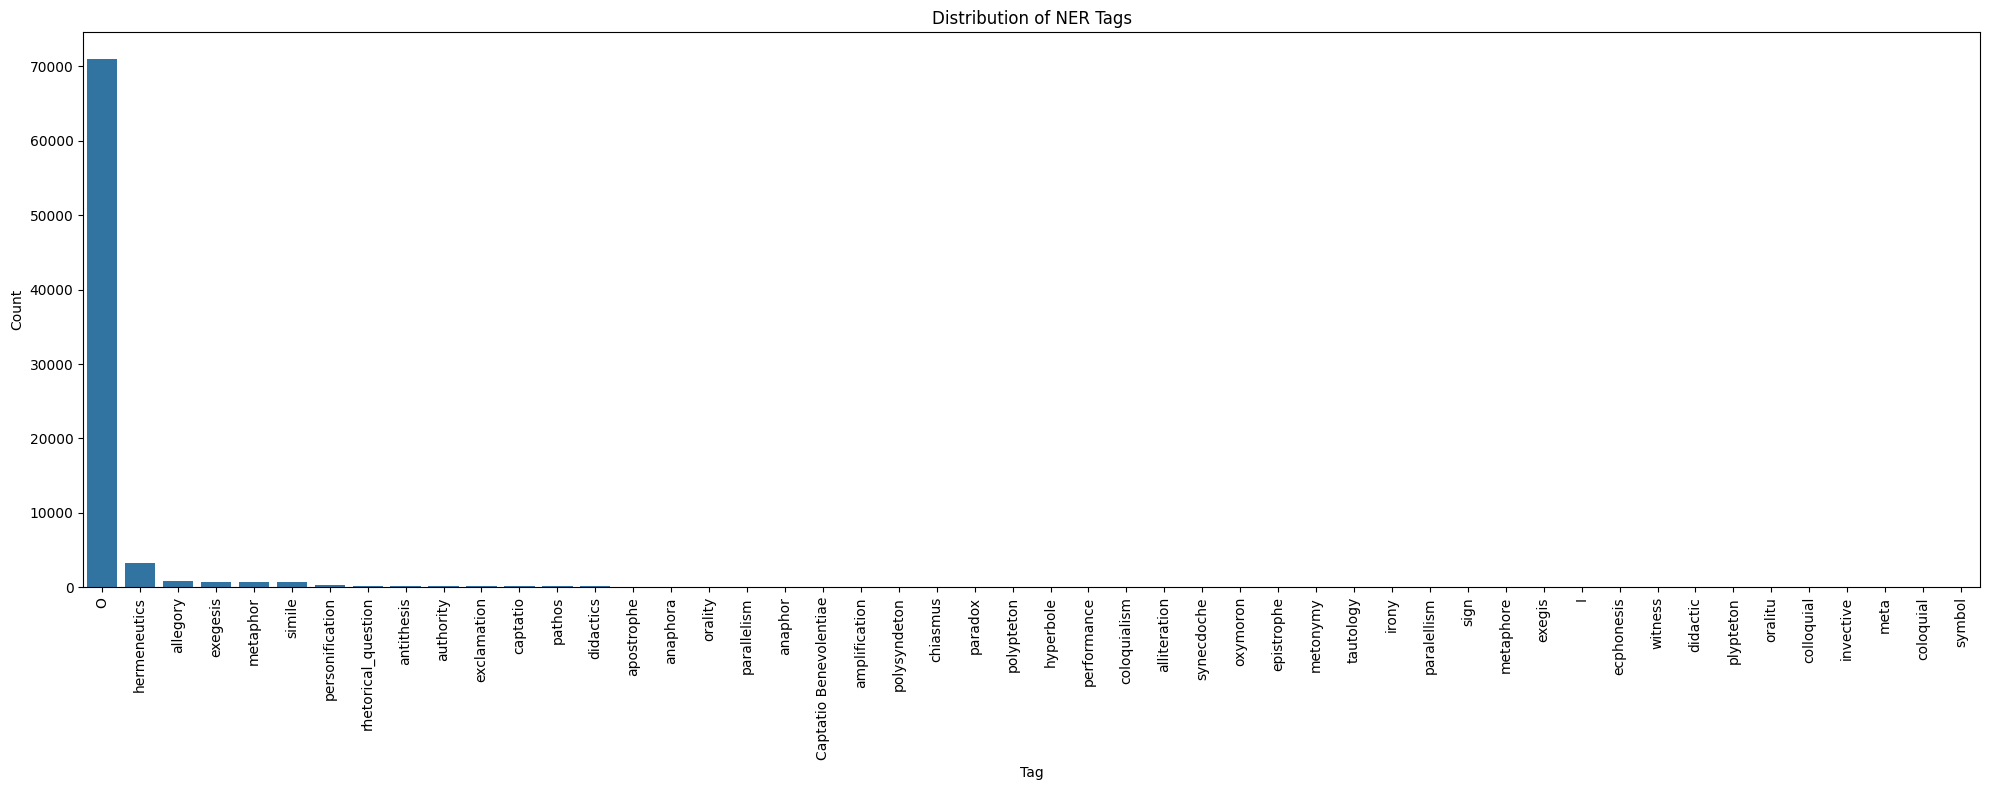

In [ ]:
plt.figure(figsize=(20, 8))
sns.barplot(x=tag_counts.index, y=tag_counts.values)
plt.title('Distribution of NER Tags')
plt.ylabel('Count')
plt.xlabel('Tag')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In case of missing values, the following code will add a placeholder tag

In [ ]:
print("\nMissing values in each column:")
display(df.isna().sum())


Missing values in each column:


,0
Sentence #,0
Word,0
Tag,0


In [ ]:
if df.isna().sum().sum() > 0:
    print("Filling missing values...")
    df = df.fillna("O")  # Common practice for NER is to use 'O' (Outside) tag for missing values

The following code will group the data by sentences

In [ ]:
print("\nGrouping words into sentences...")
sentences = []
tags = []
current_sentence = []
current_tags = []

# Group by sentence
sentence_groups = df.groupby('Sentence #')

# Process each sentence group
for sentence_num, group in tqdm(sentence_groups):
    words = group['Word'].tolist()
    sentence_tags = group['Tag'].tolist()

    # Skip empty sentences
    if len(words) > 0:
        sentences.append(words)
        tags.append(sentence_tags)

print(f"Found {len(sentences)} sentences in the dataset.")


Grouping words into sentences...


  0%|          | 0/1912 [00:00<?, ?it/s]

Found 1912 sentences in the dataset.


Creating tag mapping with special 'X' tag for subword token and doing tag to index mapping

In [ ]:
print("Creating tag mapping with special 'X' tag for subword tokens...")
unique_tags = sorted(list(set([tag for sentence_tags in tags for tag in sentence_tags])))
tag2idx = {tag: idx for idx, tag in enumerate(unique_tags)}
# Add the special 'X' tag for subword tokens
tag2idx['X'] = len(tag2idx)
idx2tag = {idx: tag for tag, idx in tag2idx.items()}

print(f"Number of unique tags: {len(tag2idx)}")
print("Tag to index mapping:")
display(tag2idx)

Creating tag mapping with special 'X' tag for subword tokens...
Number of unique tags: 51
Tag to index mapping:


{'Captatio Benevolentiae': 0,
 'I': 1,
 'O': 2,
 'allegory': 3,
 'alliteration': 4,
 'amplification': 5,
 'anaphor': 6,
 'anaphora': 7,
 'antithesis': 8,
 'apostrophe': 9,
 'authority': 10,
 'captatio': 11,
 'chiasmus': 12,
 'colloquial': 13,
 'coloquial': 14,
 'coloquialism': 15,
 'didactic': 16,
 'didactics': 17,
 'ecphonesis': 18,
 'epistrophe': 19,
 'exclamation': 20,
 'exegesis': 21,
 'exegis': 22,
 'hermeneutics': 23,
 'hyperbole': 24,
 'invective': 25,
 'irony': 26,
 'meta': 27,
 'metaphor': 28,
 'metaphore': 29,
 'metonymy': 30,
 'oralitu': 31,
 'orality': 32,
 'oxymoron': 33,
 'paradox': 34,
 'paralellism': 35,
 'parallelism': 36,
 'pathos': 37,
 'performance': 38,
 'personification': 39,
 'plypteton': 40,
 'polypteton': 41,
 'polysyndeton': 42,
 'rhetorical_question': 43,
 'sign': 44,
 'simile': 45,
 'symbol': 46,
 'synecdoche': 47,
 'tautology': 48,
 'witness': 49,
 'X': 50}

Train-test split

In [ ]:
print("Splitting data into training and validation sets...")
train_sentences, val_sentences, train_tags, val_tags = train_test_split(
    sentences, tags, test_size=0.1, random_state=RANDOM_SEED
)

print(f"Training sentences: {len(train_sentences)}")
print(f"Validation sentences: {len(val_sentences)}")

Splitting data into training and validation sets...
Training sentences: 1720
Validation sentences: 192


## Training

In [ ]:
print("Initializing BERT tokenizer...")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

Initializing BERT tokenizer...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [ ]:
class NERDataset(Dataset):
    def __init__(self, sentences, tags, tokenizer, max_len=64):
        self.sentences = sentences
        self.tags = tags
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        tags = self.tags[idx]

        encoded_sentence = []
        encoded_tags = []

        for word, tag in zip(sentence, tags):
            word_tokens = self.tokenizer.tokenize(word)

            if len(word_tokens) == 0:
                word_tokens = [self.tokenizer.unk_token]

            # Add tokenized word and tags
            encoded_sentence.extend(word_tokens)

            # ! Only the first subword gets the actual tag,
            # all other subwords get a special tag 'X'
            encoded_tags.extend([tag] + ['X'] * (len(word_tokens) - 1))

        # Add special tokens [CLS] and [SEP]
        encoded_sentence = [self.tokenizer.cls_token] + encoded_sentence + [self.tokenizer.sep_token]
        encoded_tags = ['O'] + encoded_tags + ['O']  # Use 'O' for special tokens

        # Convert tokens to ids
        input_ids = self.tokenizer.convert_tokens_to_ids(encoded_sentence)
        tags_ids = [tag2idx[tag] for tag in encoded_tags]

        attention_mask = [1] * len(input_ids)

        if len(input_ids) < self.max_len:
            # Padding
            input_ids = input_ids + [self.tokenizer.pad_token_id] * (self.max_len - len(input_ids))
            attention_mask = attention_mask + [0] * (self.max_len - len(attention_mask))
            tags_ids = tags_ids + [tag2idx['O']] * (self.max_len - len(tags_ids))
        else:
            # Truncation
            input_ids = input_ids[:self.max_len]
            attention_mask = attention_mask[:self.max_len]
            tags_ids = tags_ids[:self.max_len]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'labels': torch.tensor(tags_ids, dtype=torch.long)
        }

In [ ]:
print("Creating dataset objects...")
train_dataset = NERDataset(train_sentences, train_tags, tokenizer)
val_dataset = NERDataset(val_sentences, val_tags, tokenizer)

Creating dataset objects...


In [ ]:
batch_size = 16

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size
)

print(f"Number of training batches: {len(train_dataloader)}")
print(f"Number of validation batches: {len(val_dataloader)}")

Number of training batches: 108
Number of validation batches: 12


In [ ]:
print("Initializing BERT model for token classification...")
model = BertForTokenClassification.from_pretrained(
    'bert-base-multilingual-cased',
    num_labels=len(tag2idx),
    output_attentions=False,
    output_hidden_states=False
)

Initializing BERT model for token classification...


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.to(device)


BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-1

In [ ]:
from bitsandbytes.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)

In [ ]:
epochs = 1
total_steps = len(train_dataloader) * 3

In [ ]:
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [ ]:
def train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs=3):
    training_stats = []

    best_val_f1 = 0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch+1}/{epochs}")
        print('-' * 40)

        print('Training...')
        model.train()

        total_train_loss = 0
        train_steps = 0

        progress_bar = tqdm(train_dataloader, desc="Training", leave=True)

        for batch in progress_bar:
            model.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_train_loss += loss.item()

            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            scheduler.step()

            train_steps += 1

            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        avg_train_loss = total_train_loss / train_steps
        print(f"Average training loss: {avg_train_loss:.4f}")

        print('Evaluating...')
        model.eval()

        total_val_loss = 0
        val_steps = 0

        true_labels = []
        pred_labels = []

        with torch.no_grad():
            for batch in tqdm(val_dataloader, desc="Validation", leave=True):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                loss = outputs.loss
                total_val_loss += loss.item()

                logits = outputs.logits
                predictions = torch.argmax(logits, dim=2)

                for i in range(input_ids.shape[0]):
                    true_sentence = []
                    pred_sentence = []

                    for j in range(1, attention_mask[i].sum() - 1):  # Skip [CLS] and [SEP]
                        true_tag = idx2tag[labels[i][j].item()]
                        # uncomment the print statements after this if you want to see the predicted value along with the true value as training is happenning
                        # print("True : "+ true_tag)
                        pred_tag = idx2tag[predictions[i][j].item()]
                        # print("Pred: "+ pred_tag)

                        # Skip special tag for subword continuation
                        if true_tag != 'X':
                            true_sentence.append(true_tag)
                            pred_sentence.append(pred_tag)

                    true_labels.append(true_sentence)
                    pred_labels.append(pred_sentence)

                val_steps += 1

        avg_val_loss = total_val_loss / val_steps
        print(f"Average validation loss: {avg_val_loss:.4f}")

        val_f1 = f1_score(true_labels, pred_labels)
        val_precision = precision_score(true_labels, pred_labels)
        val_recall = recall_score(true_labels, pred_labels)

        print(f"Validation F1 Score: {val_f1:.4f}")
        print(f"Validation Precision: {val_precision:.4f}")
        print(f"Validation Recall: {val_recall:.4f}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            print(f"New best validation F1: {best_val_f1:.4f}. Saving model...")
            model_path = f"bert_ner_epoch_{epoch+1}_f1_{val_f1:.4f}.pt"
            torch.save(model.state_dict(), model_path)

        training_stats.append({
            'epoch': epoch + 1,
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_f1': val_f1,
            'val_precision': val_precision,
            'val_recall': val_recall
        })

    return training_stats

In [ ]:
print("Starting model training...")
training_stats = train_model(model, train_dataloader, val_dataloader, optimizer, scheduler, epochs)

Starting model training...

Epoch 1/1
----------------------------------------
Training...


Training:   0%|          | 0/108 [00:00<?, ?it/s]

Average training loss: 0.3610
Evaluating...


Validation:   0%|          | 0/12 [00:00<?, ?it/s]

Average validation loss: 0.1877
Validation F1 Score: 0.0000
Validation Precision: 0.0000
Validation Recall: 0.0000


/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: alliteration seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: personification seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: irony seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: metaphor seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: paradox seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.11/dist-packages/seqeval/metri

## Model Evaluation

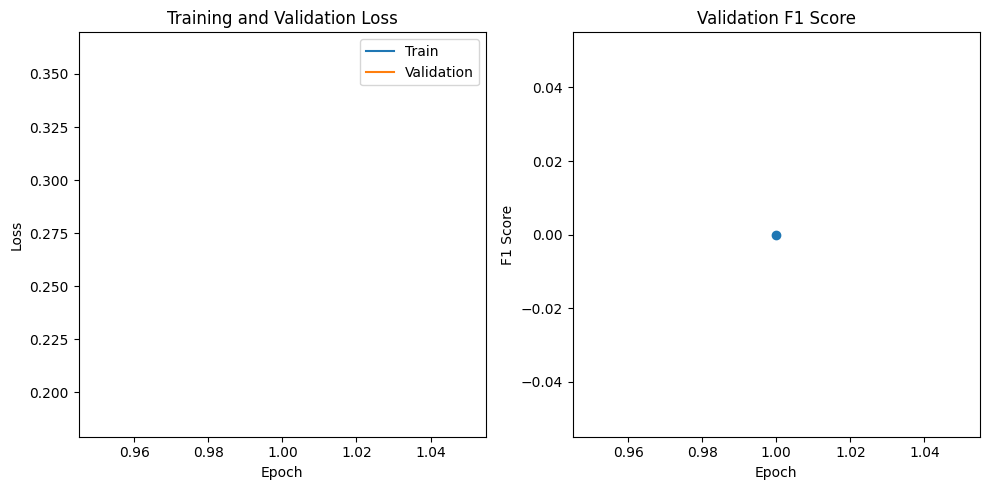

In [ ]:
stats_df = pd.DataFrame(training_stats)
stats_df = stats_df.set_index('epoch')

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(stats_df.index, stats_df['train_loss'], label='Train')
plt.plot(stats_df.index, stats_df['val_loss'], label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(stats_df.index, stats_df['val_f1'], marker='o')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.tight_layout()
plt.show()

In [ ]:
def evaluate_model(model, dataloader):
    model.eval()

    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            logits = outputs.logits
            predictions = torch.argmax(logits, dim=2)

            for i in range(input_ids.shape[0]):
                true_sentence = []
                pred_sentence = []

                # Only evaluate on non-padded tokens
                for j in range(1, attention_mask[i].sum() - 1):  # Skip [CLS] and [SEP]
                    true_tag = idx2tag[labels[i][j].item()]
                    pred_tag = idx2tag[predictions[i][j].item()]

                    # Skip special tag for subword continuation
                    if true_tag != 'X' and true_tag != 'O': # Also skip 'O' tags
                        true_sentence.append(true_tag)
                        pred_sentence.append(pred_tag)
                    elif true_tag == 'O' and pred_tag == 'O':
                         # Include 'O' tags if both true and predicted are 'O'
                         true_sentence.append(true_tag)
                         pred_sentence.append(pred_tag)


                # Filter out empty sentences before appending
                if true_sentence or pred_sentence:
                    y_true.append(true_sentence)
                    y_pred.append(pred_sentence)


    # Filter out sentences where both true and predicted are all 'O'
    filtered_y_true = []
    filtered_y_pred = []
    for true_sent, pred_sent in zip(y_true, y_pred):
        if any(tag != 'O' for tag in true_sent) or any(tag != 'O' for tag in pred_sent):
            filtered_y_true.append(true_sent)
            filtered_y_pred.append(pred_sent)


    if not filtered_y_true and not filtered_y_pred:
        print("No true or predicted entities found in the validation set.")
        return 0.0, 0.0, 0.0, "No entities to report."


    f1 = f1_score(filtered_y_true, filtered_y_pred)
    precision = precision_score(filtered_y_true, filtered_y_pred)
    recall = recall_score(filtered_y_true, filtered_y_pred)

    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    report = seqeval_report(filtered_y_true, filtered_y_pred)
    print("\nDetailed Classification Report:")
    print(report)

    return f1, precision, recall, report

In [ ]:
print("Performing detailed evaluation on validation set...")

val_f1, val_precision, val_recall, val_report = evaluate_model(model, val_dataloader)

Performing detailed evaluation on validation set...


Evaluating:   0%|          | 0/12 [00:00<?, ?it/s]

F1 Score: 0.0000
Precision: 0.0000
Recall: 0.0000

Detailed Classification Report:
                       precision    recall  f1-score   support

              aptatio       0.00      0.00      0.00         1
aptatio Benevolentiae       0.00      0.00      0.00         1
               aradox       0.00      0.00      0.00         2
                athos       0.00      0.00      0.00         1
       ersonification       0.00      0.00      0.00         3
              etaphor       0.00      0.00      0.00         6
              hiasmus       0.00      0.00      0.00         1
                imile       0.00      0.00      0.00         2
              llegory       0.00      0.00      0.00         1
          lliteration       0.00      0.00      0.00         3
         mplification       0.00      0.00      0.00         1
              naphora       0.00      0.00      0.00         2
          olysyndeton       0.00      0.00      0.00         2
            pistrophe       0.00  

/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
def predict_entities(text, model, tokenizer):
    tokens = text.split()

    bert_tokens = []
    orig_to_bert_map = []

    for token in tokens:
        orig_to_bert_map.append(len(bert_tokens) + 1)

        subwords = tokenizer.tokenize(token)

        if len(subwords) == 0:
            subwords = ['[UNK]']

        bert_tokens.extend(subwords)

    bert_tokens = ['[CLS]'] + bert_tokens + ['[SEP]']

    input_ids = tokenizer.convert_tokens_to_ids(bert_tokens)

    attention_mask = [1] * len(input_ids)

    max_len = 128
    padding_length = max_len - len(input_ids)

    if padding_length > 0:
        input_ids = input_ids + ([0] * padding_length)
        attention_mask = attention_mask + ([0] * padding_length)
    else:
        input_ids = input_ids[:max_len]
        attention_mask = attention_mask[:max_len]

    input_ids = torch.tensor([input_ids], dtype=torch.long).to(device)
    attention_mask = torch.tensor([attention_mask], dtype=torch.long).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=2)

    pred_tags = [idx2tag[p.item()] for p in predictions[0]]

    result = []
    for i, token in enumerate(tokens):
        bert_idx = orig_to_bert_map[i]
        if bert_idx < len(pred_tags):
            pred_tag = pred_tags[bert_idx]
            if pred_tag != 'O' and pred_tag != 'X':
                result.append((token, pred_tag))

    return result

In [ ]:
example_sentences = [
    "apasyonada de graves dolençi",
    "se lee que por señal de grand luto y pesar partian sus vestiduras",
    "partio su vestidura cayo en tiera."
]

In [ ]:
print("Performing inference on example sentences:")

for sentence in example_sentences:
    print(f"\nSentence: {sentence}")
    entities = predict_entities(sentence, model, tokenizer)
    print("Predicted entities:")
    for entity, tag in entities:
        print(f"  {entity}: {tag}")

Performing inference on example sentences:

Sentence: apasyonada de graves dolençi
Predicted entities:

Sentence: se lee que por señal de grand luto y pesar partian sus vestiduras
Predicted entities:

Sentence: partio su vestidura cayo en tiera.
Predicted entities:


##Model Saving

In [ ]:
final_model_path = "bert_ner_final.pt"

torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'tag2idx': tag2idx,
    'idx2tag': idx2tag
}, final_model_path)

print(f"Model saved to {final_model_path}")

Model saved to bert_ner_final.pt
